# Tutorial 1: Building and validating machine learning pipelines

(c) Aleksei Tiulpin, University of Oulu, 2018

In this tuturial you will see how you can build simple neural networks using PyTorch. 
The expected learning outcomes are the following:

* Get familiar with Python scientific stack & Jupyter Notebooks
* Get familiar with PyTorch
* Get fmailiar with optimization of neural networks
* Get hands-on experience in cross-validation



## Imports

All Python scripts and notebooks are always structured so that you **first** need to import required modules and only then use them. Imports are done as follows: `import os`.

Python ecosystem has a package manager called pip. Jupyter notebooks allow to use it right from the cells using so called magic commands:

`!pip install http://download.pytorch.org/whl/cpu/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl -U  --user`

`!pip install scikit-learn`

In [1]:
# Plotting functionality

from IPython.display import HTML

%matplotlib notebook
import matplotlib.pyplot as plt

# system-related functionality
import os

# Numeric computing
import numpy as np


# PyTorch 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import SGD

# Importing general machine learning functionality from scikit-learn
from sklearn import model_selection
from sklearn.metrics import accuracy_score

# Importing data loading functionality (I wrote them)
from routines import get_fashion_mnist
from routines import visualize_mnist
from routines import Visualizer

## CRUCIAL: remember to fix the random seed in your experiments

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED);

## Getting the data

In [3]:
X, y, X_test, y_test = get_fashion_mnist()

<IPython.core.display.Javascript object>


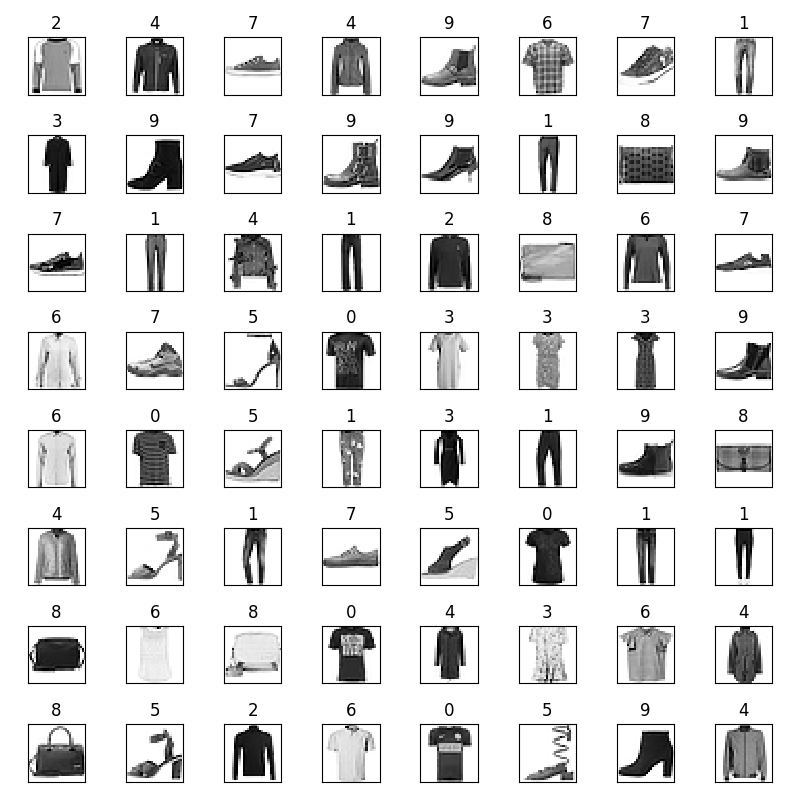

In [6]:
visualize_mnist(X, y, field_size=8) # 8x8 matrix 

## Training


### Stochastic gradient descent
The training of modern Neural Networks is done using Stochastic Gradient Descent and its variations. 

Recall from the lecture, that the optimization rule is defined as follows:

$$\theta_{t}= \theta_{t-1} - \alpha \nabla_\theta J(\theta_{t-1}; X,y)$$

where $X$ - training data, $y$ - labels, $\theta$ - parameter vector, $t$ - iteration, $\alpha$ - learnign rate and $J(\cdot)$ - loss function. Estimation of $\nabla_\theta J$ might be an extremely difficult task due to the memory restrictions. Thus, we can use the following heuristic: **instead of computing the precise value of the gradient and making one optimization step, we will make many small updates with a noisy gradient estimate**. Thus, we can reformulate the update rule:

$$\theta_{t}= \theta_{t-1} - \alpha \nabla_\theta J(\theta_{t-1}; \hat X,\hat y),$$

where $\hat X$,$\hat y$ are the randomly sampled subset (mini-batch) of the training data.

### Momentum

Unfortunately, when we train neural networks, we face a lot of difficulties: the optimization is non-convex, there exist a lot of local minimas and plateaus. To overcome this issue, let's use the following heuristic: instead of always making random updates, we will memorize the direction of the previous updates by storing the "velocity vector" by introducing momentum $\mu$. This will allow us to not get stuck on the plateu and escape the local minimas:

$$ v_{t} = \mu v_{t-1} - \alpha \nabla_\theta J(\theta_{t-1}; \hat X,\hat y),$$
$$ \theta_{t}= \theta_{t-1} + v_{t}.$$

**Rule of thumb #1**: use $\mu=0.9$ and you are gonna be fine :-)

**Rule of thumb #2**: Large learnign rate should correspond to a large minibatch! otherwise your gradient updates will be too noisy and you will go to a wrong direction. Consequntly, you will get worse results.



## Technicalities

When using PyTorch, don't forget to switch the modes of the training (train and eval) by calling *net.train()* or *net.eval()*. It affects the way how different layers work (e.g. dropout). 

Another improtant thing to notice: when you define your net and use cross-entropy function, **DO NOT** use softmax, as it is already included in the loss. In fact, softmax+Negative Log-Likelihood = Cross-Entropy!

## Neural Net definition

### PyTorch 101

The following GIF explains exactly what PyTorch is about. Th main idea of the framework is an efficient differentiation of multidimensional tensors.

In [7]:
HTML('<img src="http://pytorch.org/static/img/dynamic_graph.gif">')

### Defining computational graphs

In [13]:
class OneLayerNet(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes):
        super().__init__()
        # We first should define a hidden layer
        self.hidden = nn.Linear(n_inputs, n_hidden)
        # and then classifier
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        # computational graph is created on the fly!
        h_out = F.sigmoid(self.hidden(x))
        return self.classifier(h_out)

### Defing the training function

In [14]:
def train_epoch(net, optimizer, X, y, bs, mean, std):
    net.train()
    # Based on the batch size we decide how many batches we will need to sample
    n_batches = X.shape[0] // bs
    running_loss = 0
    for batch_n in range(n_batches):
        # First we must zero the accumulated gradient
        optimizer.zero_grad()
        
         # sampling the mini-batch indices
        batch_ind = np.random.choice(X.shape[0], bs, replace=True)
        # Normalizing the batch
        batch = (X[batch_ind, :] - mean) / std
        # converting to a tensor
        batch = torch.from_numpy(batch).float()
        # wrapping to autograd Variable
        batch = Variable(batch)

        # Creating a tensor with labels
        targets = torch.from_numpy(y[batch_ind]).long()
        # wrapping to autograd Variable
        targets = Variable(targets)
        # getting the outputs for given batch (forward pass)
        outputs = net(batch)
        # computing the loss (final node value of the computational graph)
        loss = F.cross_entropy(outputs, targets)
        # Doing backward pass
        loss.backward()
        # Now when the gradients are computed we do the gradient descent update
        optimizer.step()
        # storing the loss
        running_loss += loss.data[0]

    return running_loss / n_batches

## Validation function

Validation is exactly the same as trining. However, one minor difference is that we will use softmax to estimate the probabilities for accuracy estimation.


In [15]:
def val_epoch(net, X, y, bs, mean, std):
    net.eval()
    
    n_batches = X.shape[0] // bs
    
    # This is not very accurate - we migth lose one batch in the very end of the net!!!
    # It doesn't matter though if you have a very large dataset.
    # Be careful!
    running_loss = 0
    running_accuracy = 0
    for batch_n in range(n_batches):
        # Normalizing the batch and converting it to PyTorch autograd Variable
        batch = (X[batch_n:batch_n+bs, :] - mean) / std
        batch = torch.from_numpy(batch).float()
        batch = Variable(batch, volatile=True)

        # Converting the labels to a Variable
        targets = torch.from_numpy(y[batch_n:batch_n+bs]).long()
        targets = Variable(targets, volatile=True)
        
        # evaluating the outputs for given batch
        outputs = net(batch)
        # Computing the loss
        loss = F.cross_entropy(outputs, targets)
        # Storing the loss
        running_loss += loss.data[0]
        # Taking the softmax to normalize the probabilities
        probs = F.softmax(outputs, 1).data.numpy()
        # Storing the accuracy
        running_accuracy += accuracy_score(targets.data.numpy(), probs.argmax(1))
        
    return  running_loss / n_batches, running_accuracy / n_batches

## Putting it all together

### Hyper-parameters

In [16]:
BS = 32
StartingLR = 1e-1
WD = 1e-4
N_epochs = 20
N_folds = 5
hidden_size = 32
N_classes = 10

### Training

-> Doing Fold: 0


<IPython.core.display.Javascript object>


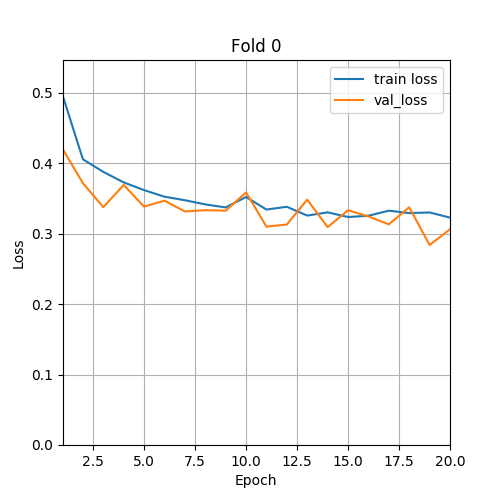

<IPython.core.display.Javascript object>


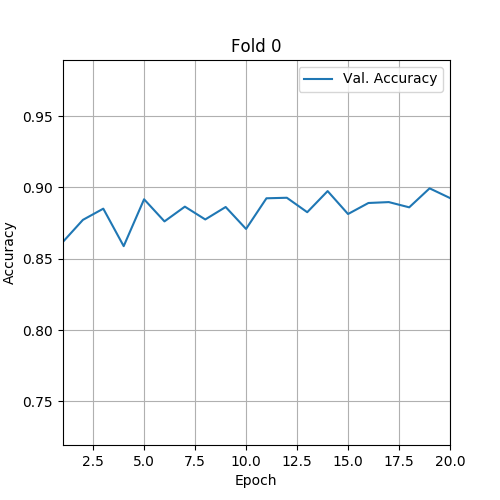

-> Doing Fold: 1


<IPython.core.display.Javascript object>


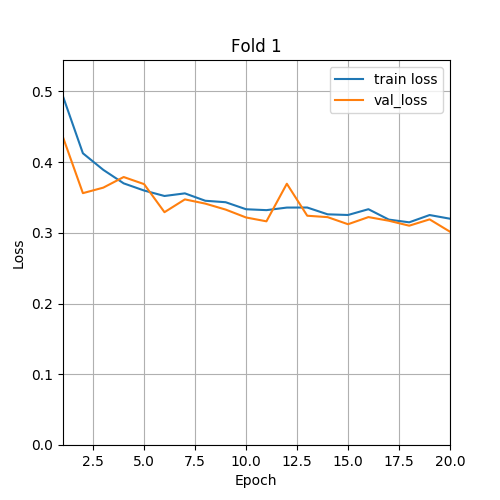

<IPython.core.display.Javascript object>


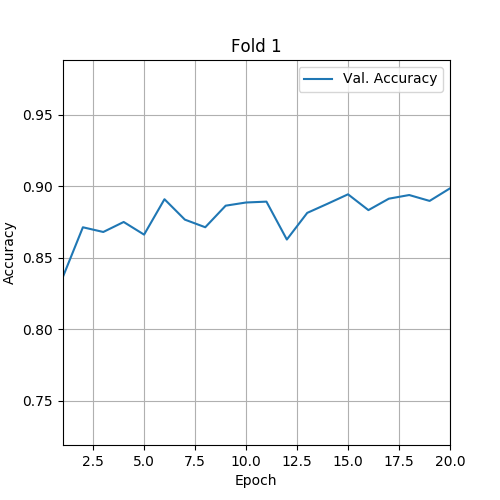

-> Doing Fold: 2


<IPython.core.display.Javascript object>


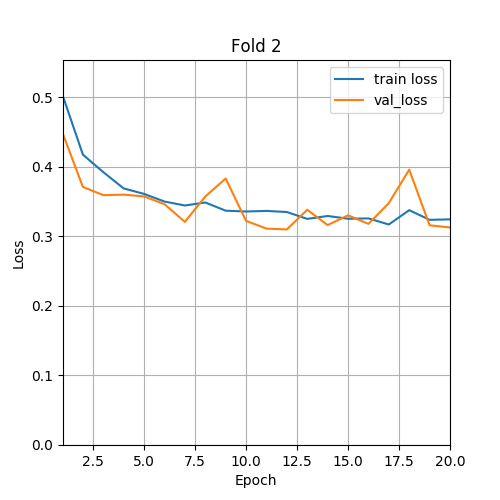

<IPython.core.display.Javascript object>


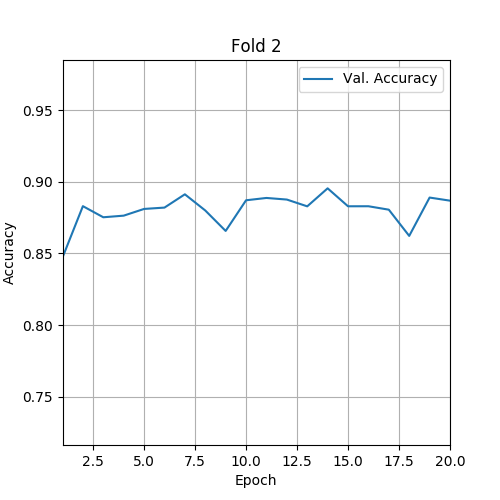

-> Doing Fold: 3


<IPython.core.display.Javascript object>


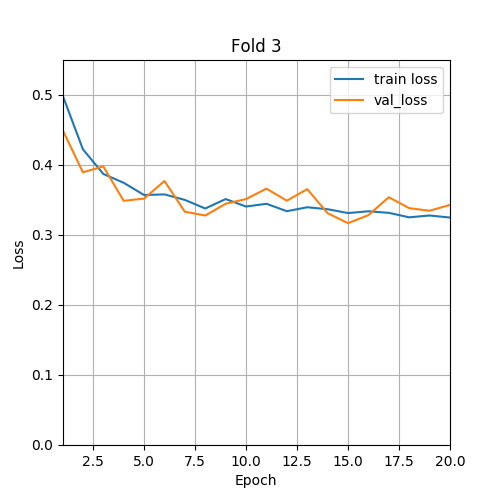

<IPython.core.display.Javascript object>


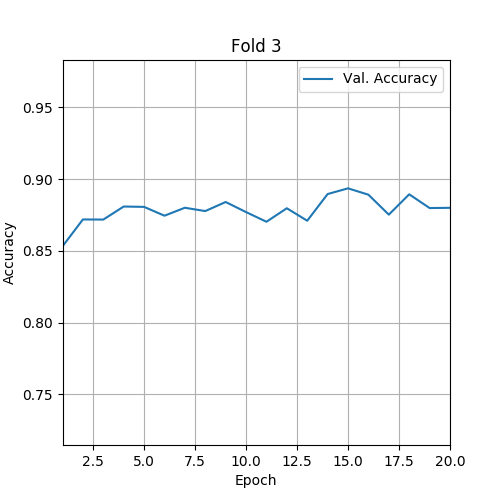

-> Doing Fold: 4


<IPython.core.display.Javascript object>


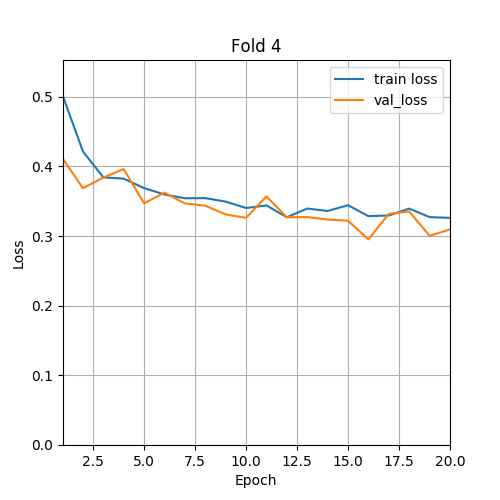

<IPython.core.display.Javascript object>


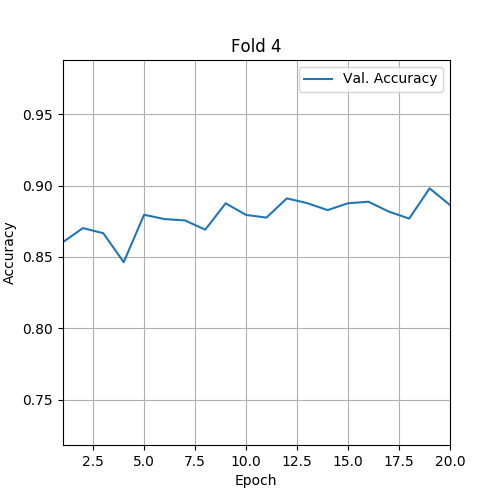

In [17]:
# mean and train std (for normalization)
mean_vect = X.mean(0)
std_vect = X.std(0)


# Folder to store the snapshots
os.system('rm -rf snapshots/')

for i in range(N_folds):
    os.makedirs('snapshots/fold_{}/'.format(i),exist_ok=True)
    
# Defing the cross-validation iterator
# Again, remember about the seed
skf = model_selection.StratifiedKFold(N_folds, shuffle=True, random_state=SEED)

logs = [] # here we will store all the logs
for fold_id, (train_ind, val_ind) in enumerate(skf.split(X,y)):
    print('-> Doing Fold:', fold_id)
    X_tr, y_tr = X[train_ind, :], y[train_ind]
    X_val, y_val = X[val_ind, :], y[val_ind]

    
    net = OneLayerNet(X_tr.shape[1], hidden_size, N_classes)
    
    # Optimizer 
    optimizer = SGD(net.parameters(), lr=StartingLR, momentum=0.9, weight_decay=WD)

    fold_logs = []
    
    # Custom visualizers buit by me. Advice: use rather TensorBoard or visdom in your own projects
    vis_loss = Visualizer((5, 5), 'Fold {}'.format(fold_id), 'Epoch', 'Loss', N_epochs, min_val=0)
    vis_acc = Visualizer((5, 5),'Fold {}'.format(fold_id), 'Epoch', 'Accuracy', N_epochs)
    
    # We will always keey only the best snapshot for each epoch to be efficient in terms of memory
    best_loss = 999999
    best_snapshot = None
    for epoch in range(1, N_epochs+1):
        # Training 1 epoch
        train_loss = train_epoch(net, optimizer, X_tr, y_tr, BS, mean_vect, std_vect)
        # Validating
        val_loss, val_acc,  = val_epoch(net, X_tr, y_tr, BS, mean_vect, std_vect)
        # Storing the logs
        fold_logs.append([train_loss, val_loss, val_acc])
        if val_loss < best_loss:
            # Saving the snapshot if it is better than the previous one (saves memory!)
            snapshot_name = 'snapshots/fold_{}/epoch_{}.pth'.format(fold_id, epoch)
            torch.save(net.state_dict(), snapshot_name)
            if best_snapshot is None:
                best_snapshot = snapshot_name
            else:
                os.remove(best_snapshot)
                best_snapshot = snapshot_name
        
        # Visualization
        if epoch > 1:
            lgs = np.array(fold_logs)
            losses = lgs[:, :2]
            accs = lgs[:, 2:].reshape(lgs.shape[0], 1)
            
            vis_loss.update_plot(losses, labels=('train loss', 'val_loss'))
            vis_acc.update_plot(accs, labels=('Val. Accuracy',))            

    logs.append(fold_logs)

## Tasks

0. Convert the logs to a numpy array
1. Estimate the validation error of your models  using the stored logs (was described in the lecture)
2. Change the hyper-parameters of your models: regularization, learning rate, batch size, number of hidden units and try to improve your validation score.
3. Try to drop learning rate after you will get on the plateau, see if you can improve your best model
4. Learn how to load the weights of your 5 models (google helps)
4. Use the test data to evaluate your basic model and the improved model